In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.image_dir = os.path.join(root_dir, "Tissues")
        self.mask_dir = os.path.join(root_dir, "Masks", "binary_mask")

        self.image_files = os.listdir(self.image_dir)
        self.mask_files = os.listdir(self.mask_dir)

        # Ensure the lists are sorted for matching image-mask pairs
        self.image_files.sort()
        self.mask_files.sort()

        # Check if the number of images and masks match
        assert len(self.image_files) == len(self.mask_files), "Number of images and masks do not match!"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        mask_name = self.mask_files[idx]

        image_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(image_path)
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create an instance of the custom dataset
dataset = CustomDataset(root_dir="G:/down_scaled_level6_train_resized", transform=transform)

In [3]:
from torch.utils.data import random_split

# Split dataset into train and validation sets
total_samples = len(dataset)
train_size = int(0.8 * total_samples)
valid_size = total_samples - train_size

train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

Train dataset


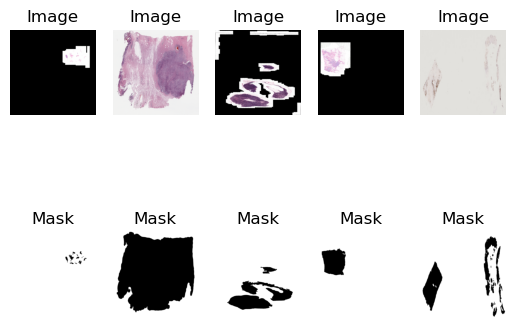

Valid dataset


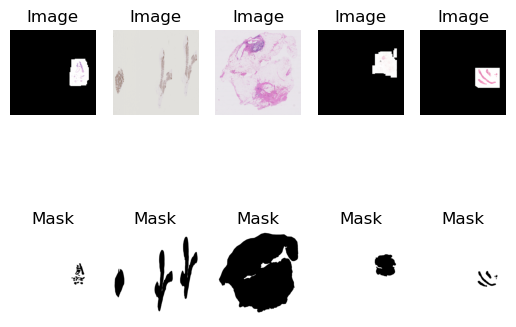

In [4]:
def display_samples(dataset, num_samples=5):
    # Assuming the dataset returns pairs of images and masks
    for i in range(num_samples):
        image, mask = dataset[i]

        plt.subplot(2, num_samples, i + 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.axis("off")
        plt.title("Image")

        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(mask[0], cmap="gray")  # Assuming masks are single-channel
        plt.axis("off")
        plt.title("Mask")

    plt.show()

# Display a few samples from your dataset
print("Train dataset")
display_samples(train_dataset, num_samples=5)

print("Valid dataset")
display_samples(valid_dataset, num_samples=5)

In [60]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
])


train_dataset.dataset.transform = train_transform
valid_dataset.dataset.transform = valid_transform

In [61]:
# Create data loaders for train and validation sets
bs = 8

train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=bs, shuffle=False)

In [65]:
import torch.nn as nn

# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2)
        )

    def forward(self, x):
        # Encoder
        x1 = self.encoder(x)

        # Decoder
        x = self.decoder(x1)

        return x



# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the device
print("Device:", device)

# Create an instance of the UNet model
model = UNet()
model.to(device)

# Print the model architecture
print(model)

criterion = nn.MSELoss()
print(criterion)
optimizer = optim.Adam(model.parameters(),lr=0.001, weight_decay=0.0001)
print(optimizer)

Device: cpu
UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
  )
)
MSELoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)


In [ ]:
from tqdm import tqdm

# Set the number of epochs
num_epochs = 30

# Initialize lists to store loss values for plotting
train_losses = []
train_dice_scores = []
valid_losses = []
valid_dice_scores = []

def dice_coefficient(y_pred, y_true):
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred)
    return (2.0 * intersection) / (union + 1e-8)

# Training loop
for epoch in range(1, num_epochs+1):
    
    model.train()
    epoch_train_loss = 0.0
    total_train_dice = 0.0
    for images, masks in  tqdm(train_dataloader, desc=f"Epoch {epoch}/{num_epochs}", unit="batch"):
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)

        # Calculate the loss
        loss = criterion(outputs, masks)
        train_batch_dice = dice_coefficient(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_train_dice += train_batch_dice.item()
        epoch_train_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = epoch_train_loss / len(train_dataloader)
    avg_train_dice = total_train_dice / len(train_dataloader)
    
    train_losses.append(avg_train_loss)
    train_dice_scores.append(avg_train_dice)

    # Validation
    
    model.eval()  
    epoch_valid_loss = 0.0
    total_valid_dice = 0.0
    with torch.no_grad():
        for images, masks in tqdm(valid_dataloader, desc=f"Epoch {epoch}/{num_epochs}", unit="batch"):
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate the validation loss
            valid_loss = criterion(outputs, masks)
            epoch_valid_loss += valid_loss.item()
            
            # Calculate the Dice coefficient for validation
            val_batch_dice = dice_coefficient(outputs, masks)
            total_valid_dice += val_batch_dice.item()

    # Calculate average validation loss for the epoch
    avg_valid_loss = epoch_valid_loss / len(valid_dataloader)
    avg_valid_dice = total_valid_dice / len(valid_dataloader)
    
    valid_losses.append(avg_valid_loss)
    valid_dice_scores.append(avg_valid_dice)
    
    # Save the trained model
    torch.save(model.state_dict(), f"unet_model_{epoch}.pth")

    # Print losses
    print(f"Epoch {epoch}/{num_epochs}, Train Loss: {avg_train_loss}")
    print(f"Epoch {epoch}/{num_epochs}, Valid Loss: {avg_valid_loss}")
    
    print(f"Epoch {epoch}/{num_epochs}, Train Dice Coeff: {avg_train_dice}")
    print(f"Epoch {epoch}/{num_epochs}, Valid Dice Coeff: {avg_valid_dice}")

Epoch 1/30: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.86s/batch]


Epoch 1/30, Train Loss: 0.36046915253003436
Epoch 1/30, Valid Loss: 0.18422625958919525
Epoch 1/30, Train Dice Coeff: 0.5984566044062376
Epoch 1/30, Valid Dice Coeff: 0.866555392742157


Epoch 2/30:  50%|██████████████████████████████████                                  | 6/12 [00:51<00:50,  8.43s/batch]

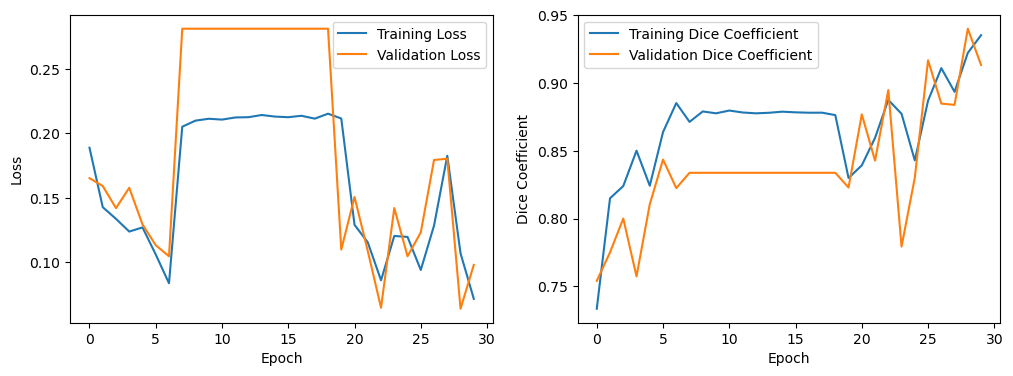

In [45]:
# Plotting loss and Dice coefficient curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_dice_scores, label='Training Dice Coefficient')
plt.plot(valid_dice_scores, label='Validation Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.show()

In [50]:
best_epoch = np.argmax(valid_dice_scores)
print(best_epoch)
saved_model_path = f"unet_model_{22}.pth"
model.load_state_dict(torch.load(saved_model_path))

28


<All keys matched successfully>

In [51]:
# Load the test dataset
test_dataset = CustomDataset(root_dir="G:/down_scaled_level6_test_resized", transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [52]:
from sklearn.metrics import jaccard_score

# Initialize lists to store predictions and ground truth masks
all_predictions = []
all_ground_truths = []

# Perform inference
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, masks in tqdm(test_dataloader):
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        predictions = model(images)

        # Store predictions and ground truth masks
        all_predictions.append(predictions.cpu().numpy())
        all_ground_truths.append(masks.cpu().numpy())

# Concatenate predictions and ground truth masks along the batch dimension
all_predictions = np.concatenate(all_predictions, axis=0)
all_ground_truths = np.concatenate(all_ground_truths, axis=0)

# Flatten and convert to binary arrays
binary_threshold = 0.5
y_true_binary = (all_ground_truths > 0.5).flatten()
y_pred_binary = (all_predictions > binary_threshold).flatten()

# Calculate Jaccard accuracy
jaccard_acc = jaccard_score(y_true_binary, y_pred_binary, average='binary')

print(f"Jaccard Accuracy: {jaccard_acc}")

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:17<00:00,  2.25it/s]


Jaccard Accuracy: 0.8395358069332558


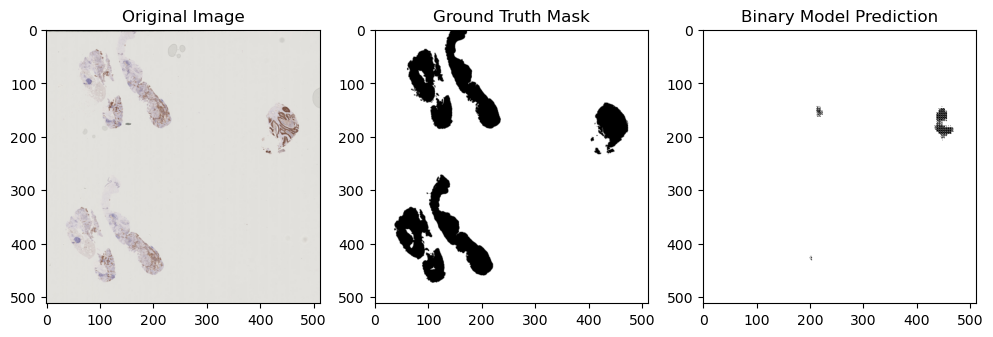

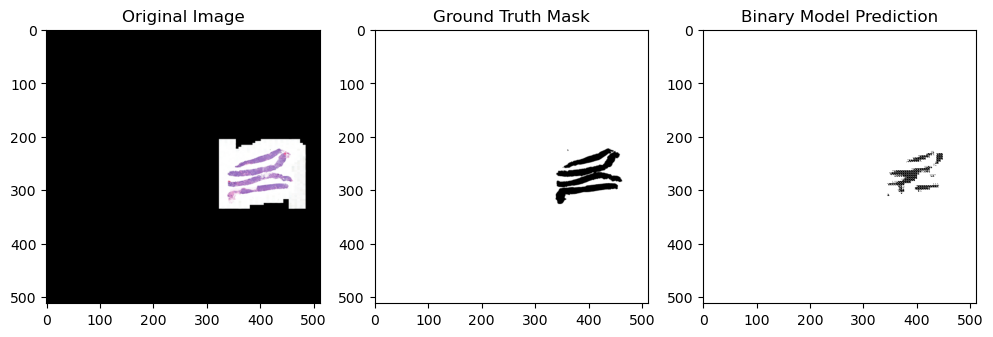

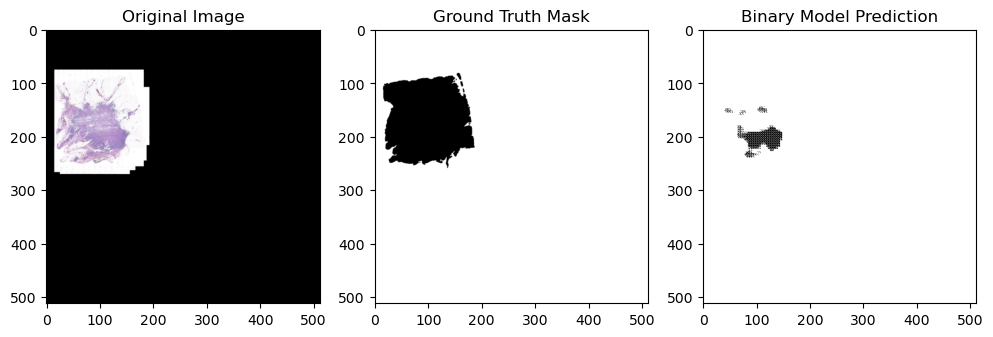

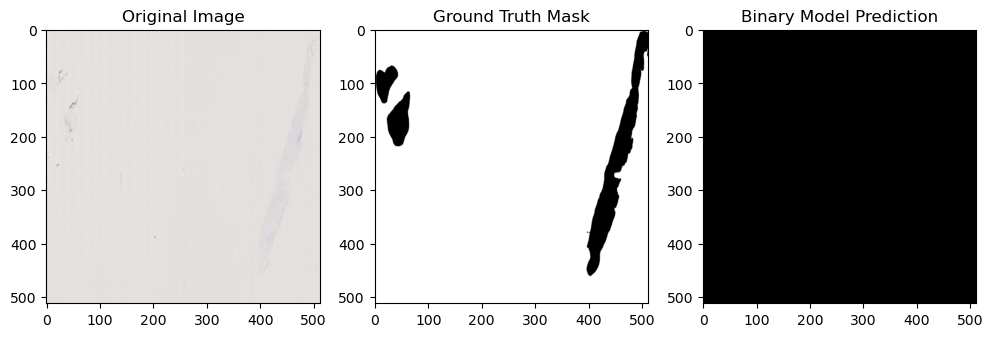

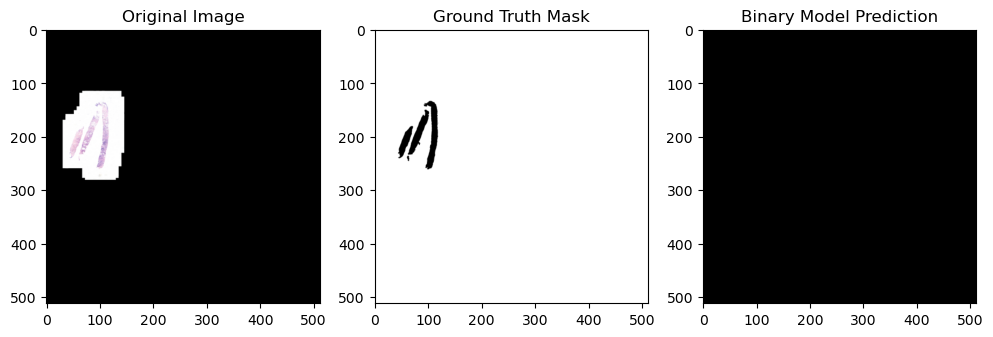

In [53]:
# Visualize samples
num_samples_to_visualize = 5
for i in range(num_samples_to_visualize):
    # Assuming each element in the dataset is a tuple (image, mask)
    sample = test_dataset[i]
    
    # Convert image and mask tensors to numpy arrays
    image = sample[0].numpy()
    mask = sample[1].numpy()
    
    model_prediction = all_predictions[i, 0] 
    binary_prediction = (model_prediction > 0.5).astype(np.uint8)  

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image.transpose((1, 2, 0)))  # Assuming the image is in the shape (3, 512, 512)
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(mask[0], cmap='gray')  # Assuming the mask is in the shape (1, 512, 512)
    plt.title("Ground Truth Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(binary_prediction, cmap='gray')  # Display binary prediction
    plt.title("Binary Model Prediction")

    plt.show()